In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np
import matplotlib.pyplot as plt
from time import time
from astropy.table import Table

from sklearn.datasets import load_iris
from mcfa import (mcfa, mpl_utils, utils)

%matplotlib inline

In [2]:
GALAH_CATALOG_PATH = "../catalogs/GALAH_DR2.1_catalog.fits"
#galah = fits.open(GALAH_CATALOG_PATH)[1].data
galah = Table.read(GALAH_CATALOG_PATH)

In [3]:
D = 15
N = 1000 # subsample the data for testing

np.random.seed(42)

element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]
print("\n".join(element_label_names))

# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)

import operator
for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]:
    print(k, v)
    
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:D - 1]

# Add in Eu.
use_element_label_names.append("eu_fe")

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

use_element_label_names.append("fe_h")
    


X = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

print("Sub-sampling {} stars (from {})".format(N, X.shape[0]))
idx = np.random.choice(X.shape[0], N, replace=False)
X = X[idx]
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    X[:, d] += X[:, fe_h_index]
    
    
label_names = np.array(["{}_h".format(ea.split("_")[0]) for ea in use_element_label_names])
    
N, D = X.shape
assert N > D
assert np.all(np.isfinite(X))

li_fe
c_fe
o_fe
na_fe
mg_fe
al_fe
si_fe
k_fe
ca_fe
sc_fe
ti_fe
v_fe
cr_fe
mn_fe
co_fe
ni_fe
cu_fe
zn_fe
y_fe
ba_fe
la_fe
eu_fe
na_fe 265806
mg_fe 264551
sc_fe 251749
ti_fe 250655
zn_fe 248993
mn_fe 247222
y_fe 244475
ca_fe 240420
ni_fe 235944
cr_fe 235783
o_fe 230613
si_fe 228337
k_fe 214247
ba_fe 206675
v_fe 184428
cu_fe 184380
al_fe 178739
la_fe 52715
eu_fe 42901
c_fe 29126
co_fe 18332
li_fe 3963
264227
na_fe 239580
mg_fe 226436
sc_fe 209213
ti_fe 195146
zn_fe 179550
mn_fe 169286
y_fe 155500
ca_fe 146109
ni_fe 134787
cr_fe 125124
o_fe 111499
si_fe 101675
k_fe 86929
ba_fe 77881
eu_fe 7984
Sub-sampling 1000 stars (from 7984)


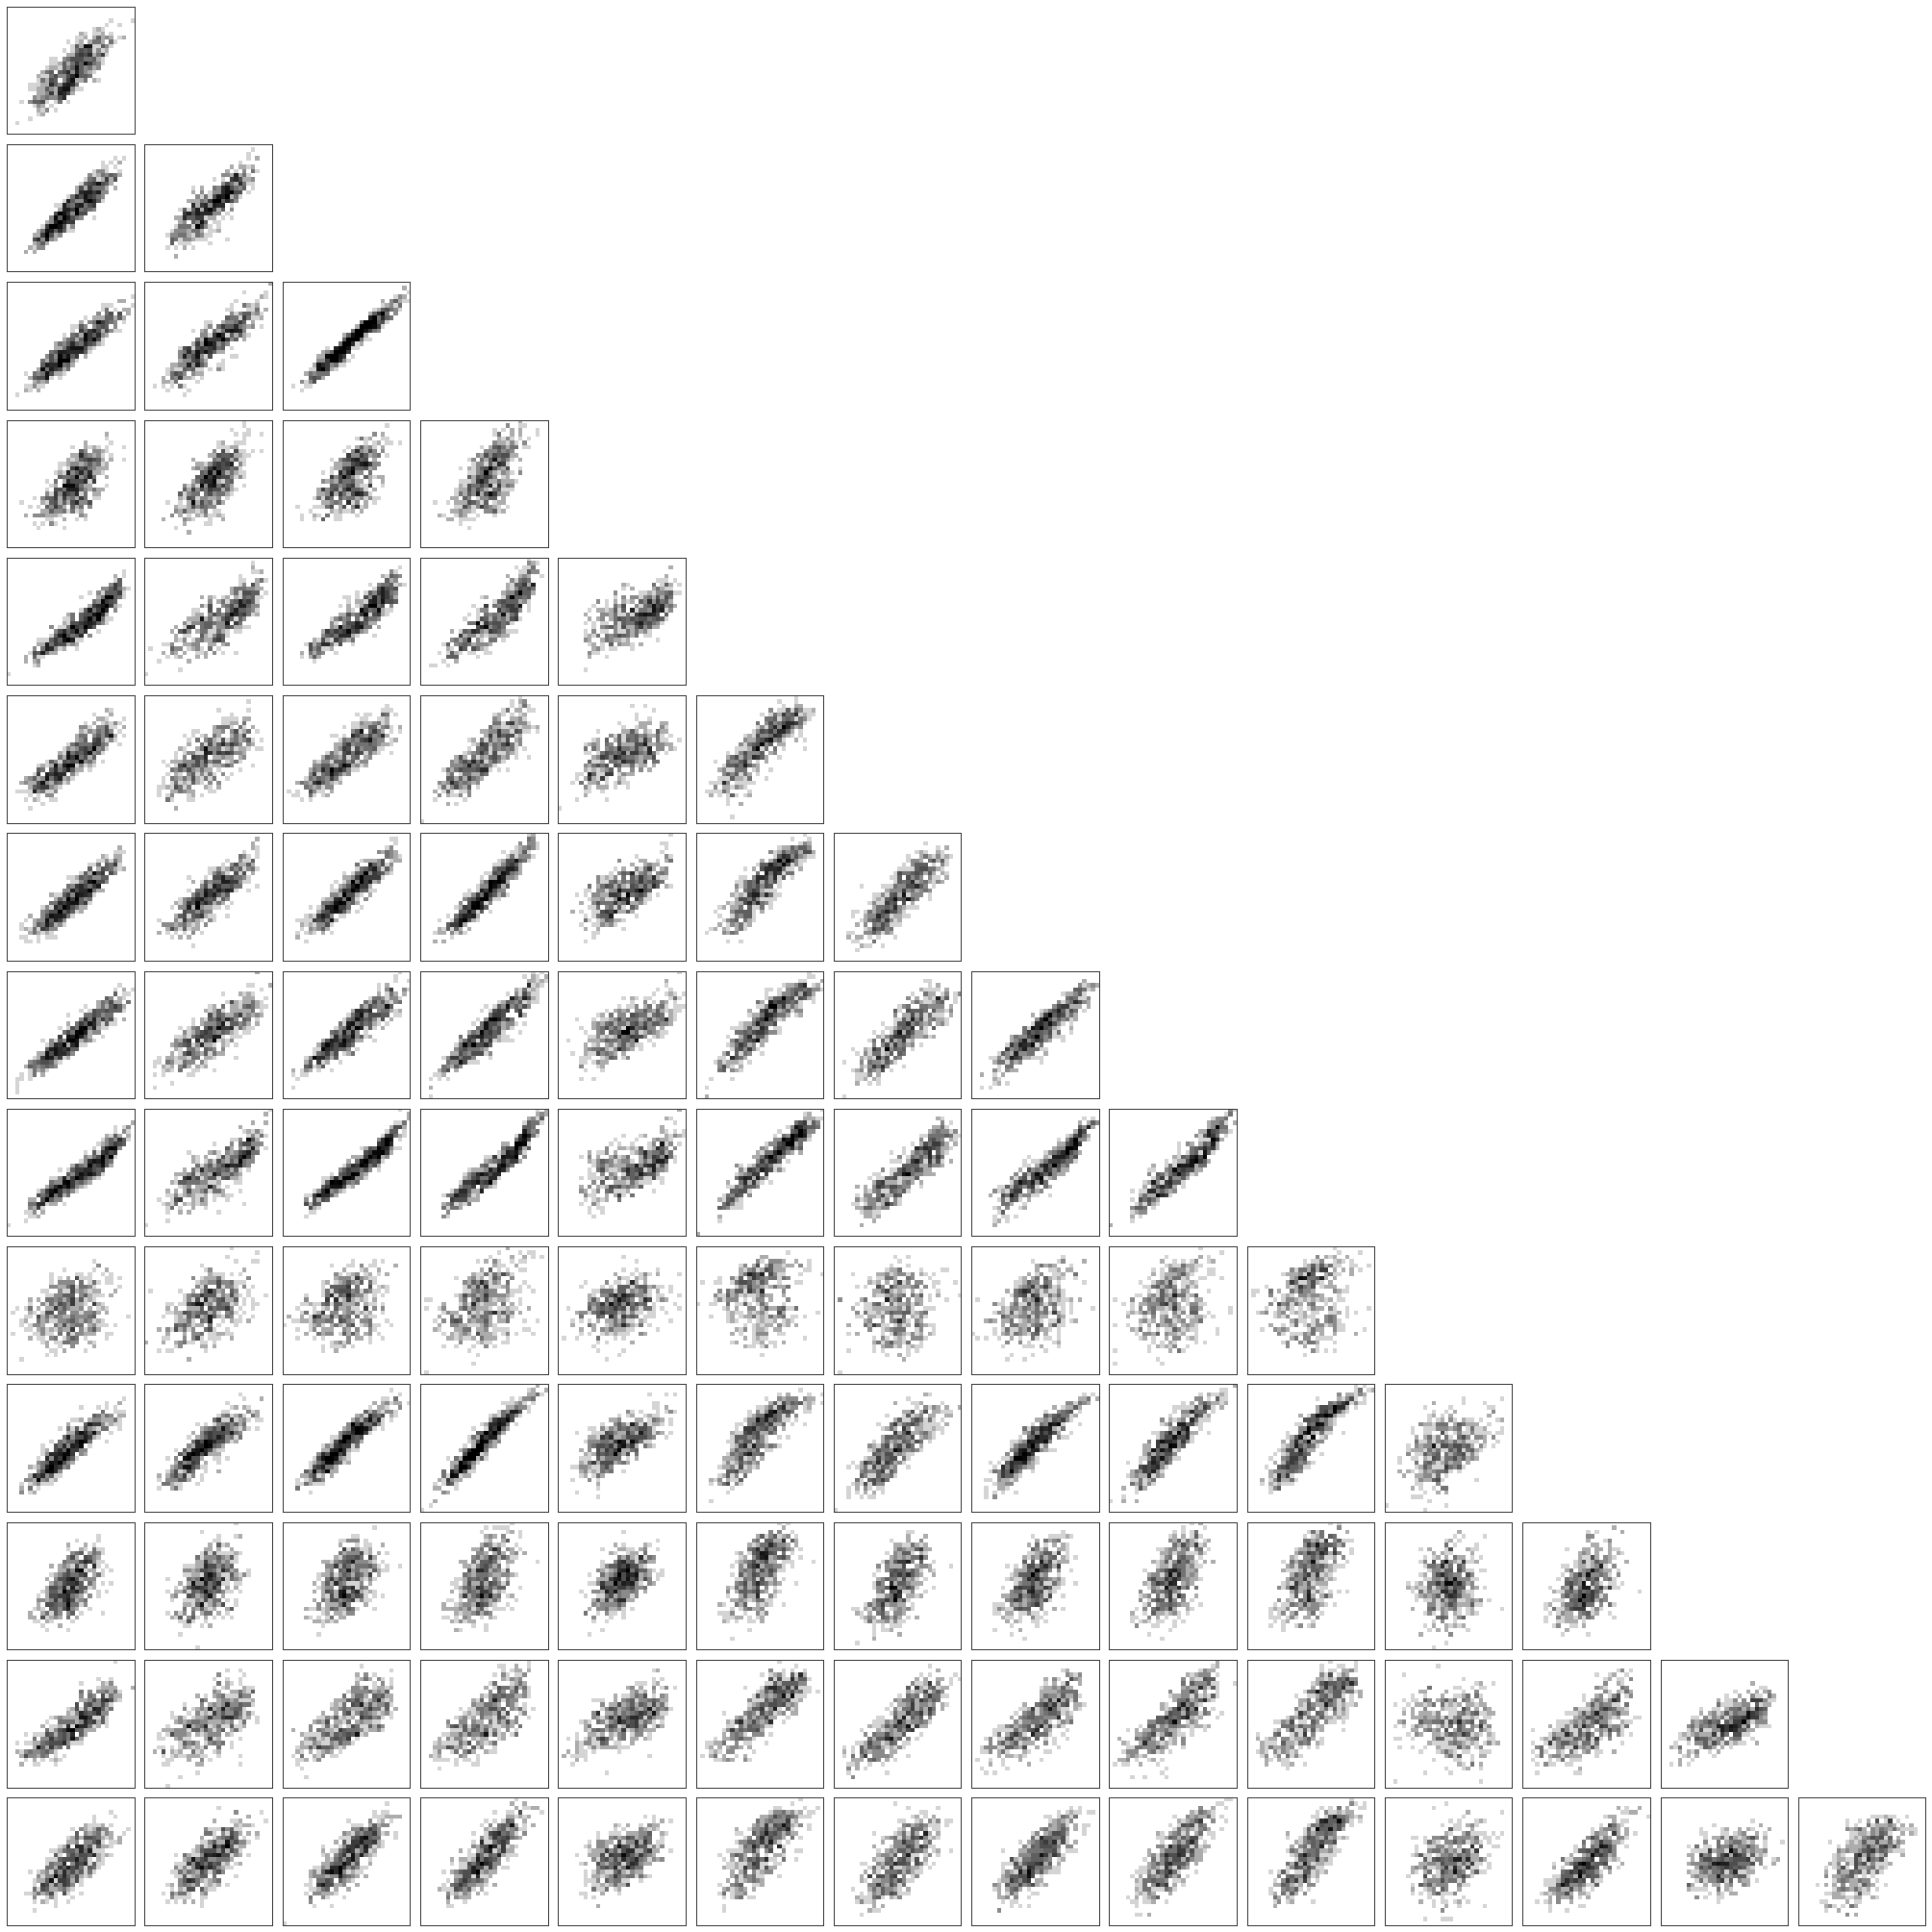

In [4]:
fig = mpl_utils.corner_hist(X)

In [5]:
J = 3 # number of latent factors
K = 5 # number of clusters

t_init = time()

model = mcfa.MCFA(n_latent_factors=J, n_components=K, 
                  n_random_init=0, n_init=1, init_method="eigen-A")
model.fit(X)

t_opt = time() - t_init

print("Took {:.0f}s to optimize. ll = {:.0f}".format(t_opt, model.log_likelihood_))

Took 9s to optimize. ll = 13078


In [6]:
for parameter_name, value in dict(zip(model.parameter_names, model.theta_)).items():
    print("{}: {}\n{}".format(parameter_name, value.shape, value))

pi: (5,)
[0.11927371 0.24505943 0.09726587 0.36379998 0.17460102]
A: (16, 3)
[[-0.25089233  0.04468333  0.00742035]
 [-0.12618392 -0.0838509  -0.25582369]
 [-0.2334585   0.11297788 -0.22785561]
 [-0.2054273  -0.11860331 -0.2773606 ]
 [-0.17131566  0.09241217 -0.04412027]
 [-0.39628478  0.47797385  0.1631433 ]
 [-0.31298349 -0.0392859   0.15014409]
 [-0.1945864  -0.0442426  -0.1343025 ]
 [-0.31104486 -0.61799749 -0.0695026 ]
 [-0.34798164  0.2969827  -0.06866623]
 [-0.00515605 -0.11011378 -0.47150608]
 [-0.20291652 -0.12814095 -0.30420114]
 [-0.12315386 -0.14506893  0.19001314]
 [-0.34517369 -0.34156743  0.57039191]
 [-0.14611548 -0.09539819 -0.2288506 ]
 [-0.29323456  0.27406643 -0.05368053]]
xi: (3, 5)
[[-1.13620286  0.17581706 -0.73481228  0.9838814  -0.25709296]
 [-0.42475444 -0.27904758 -0.28860187 -0.2495848  -0.23339462]
 [-0.21881993  0.31232454 -0.05477821 -0.07165263 -0.11213066]]
omega: (3, 3, 5)
[[[ 0.08708245  0.30804659  0.07601039  0.33529171  0.17680426]
  [ 0.00049129  

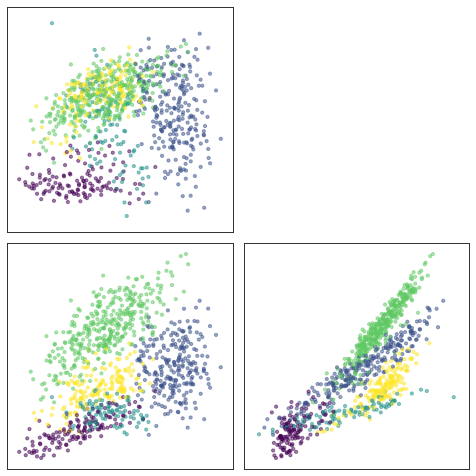

In [7]:
# Plot the estimated posterior factor scores.
#fig = mpl_utils.corner_scatter(X, s=10, alpha=0.75, figsize=(10, 10))
v, v_cluster, v_mean = model.factor_scores(X)

# Associations
hard_associations = np.argmax(model.tau_, axis=1)

fig = mpl_utils.corner_scatter(v_mean, c=hard_associations, figsize=(10, 10), s=10)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)


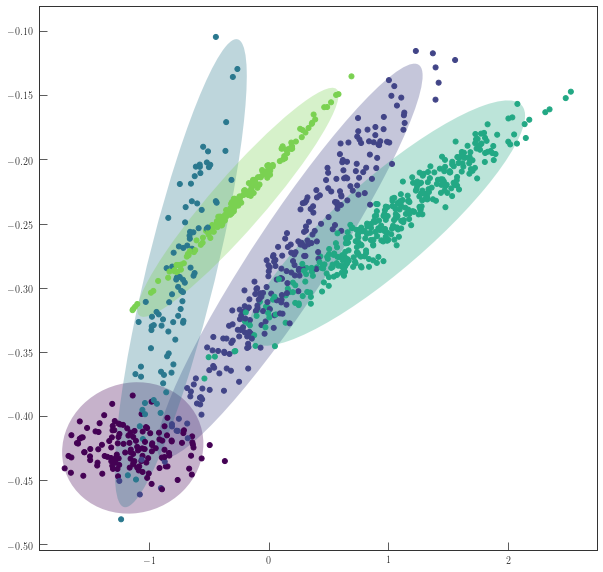

In [22]:
from matplotlib.patches import Ellipse


fig, ax = plt.subplots(figsize=(10, 10))
scat = ax.scatter(v_cluster.T[0], v_cluster.T[1],
                  c=hard_associations, vmin=0, vmax=model.n_components)

cmap = scat.get_cmap()

mus = model.theta_[model.parameter_names.index("xi")]
covs = model.theta_[model.parameter_names.index("omega")]

for i, (mu, cov) in enumerate(zip(mus.T, covs.T)):
    
    print(cov.shape)
    cov_ = cov[:2, :2]
    vals, vecs = np.linalg.eigh(cov_)
    order = vals.argsort()[::-1]
    vals = vals[order][:2]
    vecs = vecs[:, order][:2]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    color = scat.to_rgba(i)
    
    width, height = 2.0 * 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=mu[:2], width=width, height=height, angle=theta,
                      facecolor=color, zorder=-1, alpha=0.3)
    ax.add_artist(ellipse)
    

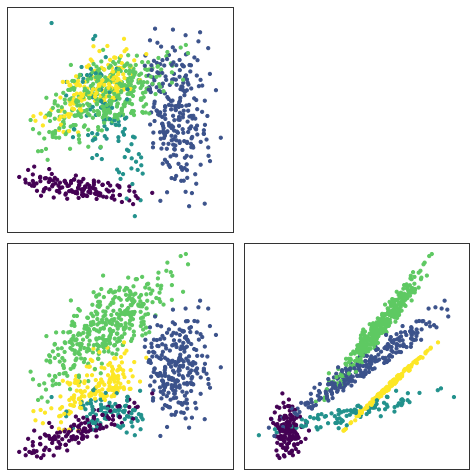

In [11]:
fig = mpl_utils.corner_scatter(v_cluster, c=hard_associations, figsize=(10, 10), alpha=1, s=10)

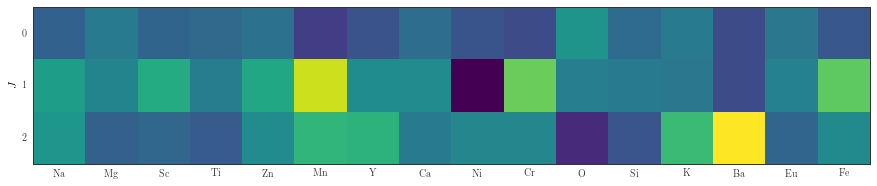

In [12]:
# Plot loads?
factor_loads = model.theta_[model.parameter_names.index("A")].T

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.imshow(factor_loads, interpolation="nearest")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_yticks(np.arange(model.n_latent_factors))
ax.set_ylabel(r"$J$")

ax.set_xticks(np.arange(D))
_ = ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

[Text(0,0,'\\textrm{Na}'),
 Text(0,0,'\\textrm{Mg}'),
 Text(0,0,'\\textrm{Sc}'),
 Text(0,0,'\\textrm{Ti}'),
 Text(0,0,'\\textrm{Zn}'),
 Text(0,0,'\\textrm{Mn}'),
 Text(0,0,'\\textrm{Y}'),
 Text(0,0,'\\textrm{Ca}'),
 Text(0,0,'\\textrm{Ni}'),
 Text(0,0,'\\textrm{Cr}'),
 Text(0,0,'\\textrm{O}'),
 Text(0,0,'\\textrm{Si}'),
 Text(0,0,'\\textrm{K}'),
 Text(0,0,'\\textrm{Ba}'),
 Text(0,0,'\\textrm{Eu}'),
 Text(0,0,'\\textrm{Fe}')]

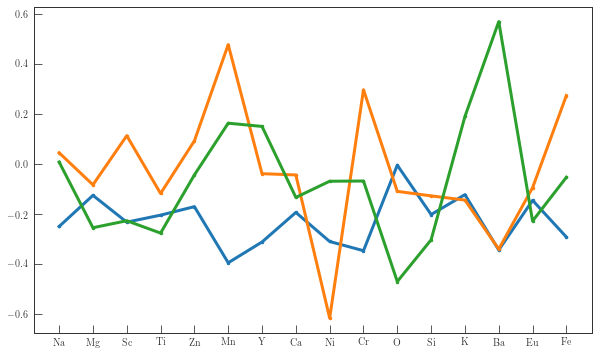

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
for j in range(model.n_latent_factors):
    ax.plot(factor_loads[j], lw=3)
ax.set_xticks(range(D))
ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

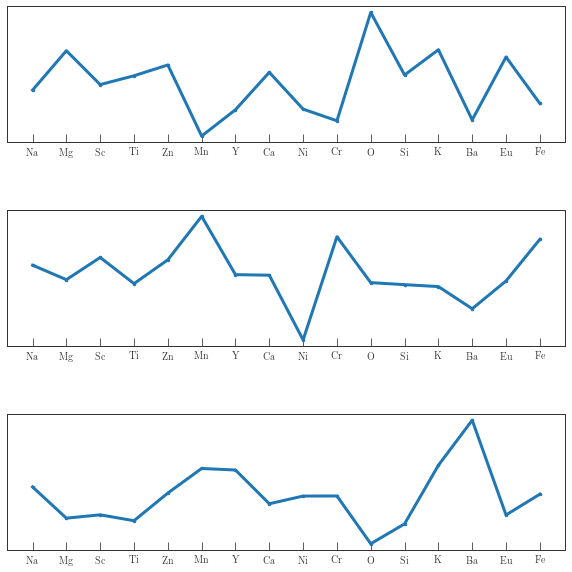

In [14]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names])
    
    ax.set_yticks([])

In [19]:
# Group by "physics"
light_odd_z = ["Na", "K"]
fe_peak = ["Sc", "Cr", "Mn", "Fe", "Ni", "Zn"]
s_process = ["Y", "Ba"]
alpha = ["O", "Mg", "Si", "Ca", "Ti"]
r_process = ["Eu"]

ordered_label_names = light_odd_z \
                    + alpha \
                    + fe_peak \
                    + s_process \
                    + r_process

# ordered label indices
oli = np.array([list(label_names).index("{}_h".format(_.lower())) for _ in ordered_label_names])


assert len(set(ordered_label_names)) == len(set(label_names))



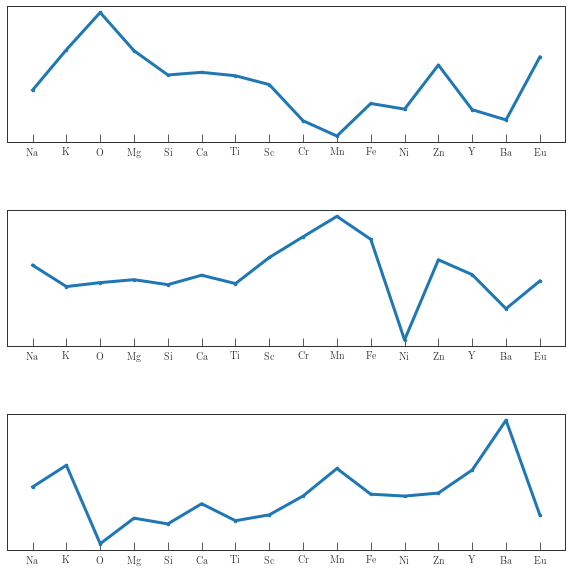

In [23]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j][oli], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names[oli]])
    
    ax.set_yticks([])